# 2D objective analysis of weather radar RHI scan: Fast Barnes Interpolation Example

This example uses the Fast Barnes interpolation methods as presented in [Zürcher (2023)](https://doi.org/10.5194/gmd-16-1697-2023) available at [fast-barnes-py](https://github.com/MeteoSwiss/fast-barnes-py.git).

The notebook applies the fast Barnes interpolation methods to RHI scan data from the ARM-CSAPR2 radar data from the [TRACER] (https://www.arm.gov/research/campaigns/amf2021tracer) field campaign.

---

## Overview

This notebook shows how to download the ARM-CSAPR2 RHI data from ARM data repository and grid radar variables on a two-dimensional Cartesian grid using Python.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import pyart
import act
import glob
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy
from fastbarnes.interpolation import barnes
from datetime import timedelta


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

In [2]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

datastream = "houcsapr2cfrS2.a1"

start_date = "2022-08-07T18:39:04"
end_date = "2022-08-07T18:39:05"

## Grab Data
We use the ARM Live API, accessible through ACT!
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.download_data.html#act.discovery.download_data)

We are interested in the C-band radar, which is utilizing a cell-tracking algorithm, with the datastream
- `houcsapr2cfrS2.a1`

One of the better cases was from June 2, 2022.

This line will download data into the a new directory with the datastream name (`/houcsapr2cfrS2.a1`)

In [3]:
aug7_csapr_files = act.discovery.download_data(arm_username,
                                               arm_password,
                                               datastream,
                                               start_date,
                                               end_date)

[DOWNLOADING] houcsapr2cfrS2.a1.20220807.183904.nc



If you use these data to prepare a publication, please cite:

Bharadwaj, N., Collis, S., Hardin, J., Isom, B., Lindenmaier, I., Matthews, A.,
& Nelson, D. C-Band Scanning ARM Precipitation Radar (CSAPR2CFR). Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1467901



## Read in and Plot the Data
Before following running the next cells, make sure you have created the following directories:
- `quicklooks`

In [4]:
!mkdir quicklooks

mkdir: cannot create directory ‘quicklooks’: File exists


In [5]:
radar_file = "houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183904.nc"

## Plot one of the RHI scans
We read in the data corresponding to 7 August 2022 18:39:04 UTC, and plot a basic `RadarDisplay` which will automatically detect whether the plot is a vertical cross section (RHI or VPT), or a horizontal scan (PPI)

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


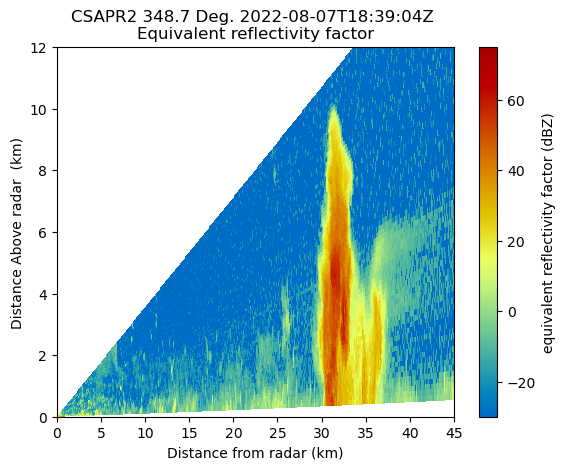

In [6]:
radar = pyart.io.read(radar_file)
display = pyart.graph.RadarDisplay(radar)
display.plot("reflectivity", 0)
plt.savefig(f"quicklooks/{Path(radar_file).stem}.png", dpi=200)
plt.xlim(0,45)
plt.ylim(0,12)
plt.show()
plt.close() 

## Define a function to grid the RHI data from polar (antenna) coordinates to a two-dimensional Caretsian grid
We use numba to vectorize the `dist_func` function to calculate the distance of each range gate from the radar. This makes our code run faster than simply executing this function for each gate in a for loop.

Next, we use the `barnes` function from the fastbarnes Python package to interpolate the radar fields such as `equivalent reflectivity factor` ($Z_{H}$), `differential_reflectivity` ($Z_{DR}$), and `specific_differential_phase` ($K_{DP}$) to a uniform range-height Cartesian grid.

In [7]:
def grid_rhi(file,z_res = 100,rng_res = 100,z_limits = (0,15000),rng_limits = (0,109900.0),fields=None):
    
    """
    Input:
    -------
    file (str): Path of the RHI scan file that needs to be gridded.
    z_res (float): Vertical grid spacing of the Cartesian grid.
    rng_res (float): Horizontal grid spacing of the Cartesian grid.
    z_limits (tuple): Lower and upper height limits within which radar data needs to be gridded. 
    rng_limits (tuple): Lower and upper range limits within which radar data needs to be gridded. 
    
    Output:
    -------
    grid_ds (xarray Dataset): Xarray dataset containing radar fields on the Cartesian grid
    """
    
    z_pts = np.arange(z_limits[0],z_limits[1]+z_res,z_res)
    rng_pts = np.arange(rng_limits[0],rng_limits[1]+rng_res,rng_res)
   
    
    rhi = xr.open_dataset(file)
    radar = pyart.io.read(file)
    rhi = rhi.swap_dims({'time':'elevation'})

    lat = float(radar.latitude["data"])
    lon = float(radar.longitude["data"])

    grid_origin = (lat, lon)
    grid_origin_lat, grid_origin_lon = grid_origin

    grid_projection = {"proj": "pyart_aeqd", "_include_lon_0_lat_0": True}
    projparams = grid_projection.copy()

    if projparams.pop("_include_lon_0_lat_0", False):
        projparams["lon_0"] = grid_origin_lon
        projparams["lat_0"] = grid_origin_lat

    rg_loc = np.tile(radar.range['data'],len(radar.elevation['data'])).reshape(len(radar.elevation['data']),len(radar.range['data']))

    zg_loc = radar.gate_altitude["data"] - 12 # CSAPR2 antenna altitude = 12 m in this example

     
    # one of [ 'naive', 'radius', 'convolution', 'optimized_convolution' ]
    method = "optimized_convolution"

    # one of [ 0.25, 0.5, 1.0, 2.0, 4.0 ]
    sigma = 1.0

    # applies only to 'convolution' interpolations: one of [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50 ]
    num_iter = 4
    
    if fields is None:
        fields = ['reflectivity','differential_reflectivity','specific_differential_phase',
                  'copol_correlation_coeff','mean_doppler_velocity','spectral_width']
        
    res_field = np.empty((len(z_pts),len(rng_pts),len(fields)))

    for j in range(len(fields)):

        data = deepcopy(np.array(radar.fields[fields[j]]['data']))
        # data = data.filled(np.nan)

        res_field[:,:,j] = barnes(np.asarray([rg_loc.ravel(),radar.gate_altitude['data'].ravel()]).transpose(),
                           data.ravel(),
                           100,
                           np.asarray([0,0]),
                           100,
                           (len(z_pts),len(rng_pts)),
                           method=method,
                           num_iter = num_iter,
                           min_weight=0.0002
                          )
    

    data_dict = {}
    for k in range(len(fields)):
        data_dict[fields[k]] = (["z","range"],res_field[:,:,k])

    grid_ds = xr.Dataset(data_vars=data_dict,
                         coords=dict(z=(["z"], z_pts),
                                     range=(["range"],rng_pts),
                                    ),
                         attrs=dict(description="Gridded RHI data."),
                        )
        
    return grid_ds

### Apply the gridding function to your radar RHI data file

Now, we are ready to grid the RHI data. The `grid_rhi` function requires the user to specify the vertical and horizontal grid spacing (`z_res` and `rng_res`, respectively), as well as the lower and upper limits of the Cartesian grid in the vertical and horizontal dimensions (`z_limits` and `rng_limits`, respectively). Custom fields of interest can be specified through the `fields` parameter. Otherwise, the function grids five radar fields by default i.e., ($Z_{H}$, $Z_{DR}$, $\rho_{hv}$, $K_{DP}$, and $\sigma$).

In [8]:
grid_ds = grid_rhi(radar_file)

## Grid and plot the RHI data


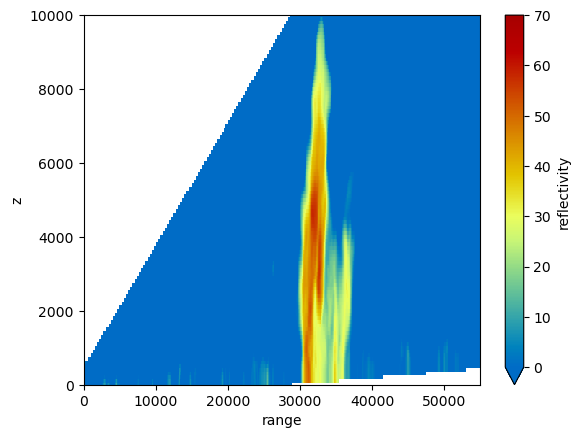

In [9]:
# Finally, plot the gridded reflectivity
fig,ax = plt.subplots()
grid_ds['reflectivity'].plot(vmin=0,vmax=70,cmap='pyart_HomeyerRainbow',ax=ax)
ax.set_xlim(0,55000)
ax.set_ylim(0,10000)
plt.show()

---

## Summary
Within this example, we walked through how to access ARM data from a field campaign in Texas, plot a quick look of the RHI scan data, and grid our RHI data from native (polar) coordinates to a uniform range-height Caretsian grid.

## Resources and References
* [ARM Data Discovery](https://adc.arm.gov/discovery)
* [TRACER Field Campaign](https://www.arm.gov/research/campaigns/amf2021tracer)
* CSAPR Radar Data:
    - Bharadwaj, N., Collis, S., Hardin, J., Isom, B., Lindenmaier, I., Matthews, A., & Nelson, D. C-Band Scanning ARM Precipitation Radar (CSAPR2CFR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1467901
* Py-ART:
    - Helmus, J.J. & Collis, S.M., (2016). The Python ARM Radar Toolkit (Py-ART), a Library for Working with Weather Radar Data in the Python Programming Language. Journal of Open Research Software. 4(1), p.e25. DOI: http://doi.org/10.5334/jors.119
* ACT:
    - Adam Theisen, Ken Kehoe, Zach Sherman, Bobby Jackson, Alyssa Sockol, Corey Godine, Max Grover, Jason Hemedinger, Jenni Kyrouac, Maxwell Levin, Michael Giansiracusa (2022). The Atmospheric Data Community Toolkit (ACT). Zenodo. DOI: https://doi.org/10.5281/zenodo.6712343